# Script 02: Machine learning
How well can we predict a relapse?

This script takes the final dataset; filters for data to be used in the pipeline (filtering for bias reduction); and executes a stratified k-fold group cross-validation (the answers given by one user constitute one group). We conduct a 5-fold nested cross-validation and store the results for each of the 5 folds in pickle files - to be analyzed in the next script.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#pd.options.display.max_rows = 100
#pd.options.display.min_rows = 100

In [2]:
import pandas as pd
import numpy as np

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import (recall_score, precision_score, f1_score, explained_variance_score, mean_squared_error,
                            mean_absolute_error, r2_score, confusion_matrix, roc_auc_score, average_precision_score,
                            accuracy_score, plot_confusion_matrix, precision_recall_curve, auc)

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import pickle

# Helper Functions and Classes

In [3]:
# for storing our results
class results:

    # parameterized constructor
    def __init__(self, search, y_test, y_test_predict, X_test, X_train, y_train, groups,
                 y_df, X_df, train_index, test_index, cnt, pipe, searchspace):
        self.search = search
        self.y_test = y_test
        self.y_test_predict = y_test_predict
        self.X_test = X_test
        self.X_train = X_train
        self.y_train = y_train
        self.groups = groups
        self.y_df = y_df
        self.X_df = X_df
        self.train_index = train_index
        self.test_index = test_index
        self.cnt = cnt
        self.pipe = pipe
        self.searchspace = searchspace

# Load data

In [4]:
df = pd.read_csv('data/final_dataset.csv')

# Filter data to be used
In order to avoid a bias by overrepresenting specific participants, we filter to only consider
users with at least 7 entries and using only up to 200 entries per user.

number of users with at least 1 entry: 441
number of rows: 11645


(array([289.,  48.,  33.,  18.,  20.,   9.,   2.,   4.,   4.,   2.,   0.,
          0.,   1.,   1.,   3.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.  ,  15.48,  29.96,  44.44,  58.92,  73.4 ,  87.88, 102.36,
        116.84, 131.32, 145.8 , 160.28, 174.76, 189.24, 203.72, 218.2 ,
        232.68, 247.16, 261.64, 276.12, 290.6 , 305.08, 319.56, 334.04,
        348.52, 363.  , 377.48, 391.96, 406.44, 420.92, 435.4 , 449.88,
        464.36, 478.84, 493.32, 507.8 , 522.28, 536.76, 551.24, 565.72,
        580.2 , 594.68, 609.16, 623.64, 638.12, 652.6 , 667.08, 681.56,
        696.04, 710.52, 725.  ]),
 <a list of 50 Patch objects>)

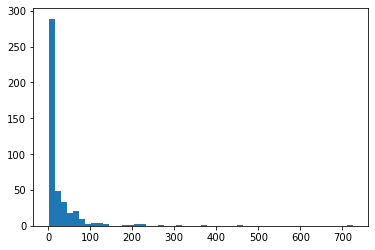

In [5]:
print('number of users with at least '+str(1)+' entry: '+str(df['responderId'].nunique()))
print('number of rows: '+str(len(df.index)))
plt.hist(df['responderId'].value_counts(), bins=50)

In [6]:
# add counts
df2 = df.groupby(["responderId"]).size().to_frame(name='count_tmp').reset_index()

# merge df1 and df2
df3 = pd.merge(df, df2,  how='left', left_on=['responderId'], right_on = ['responderId'])

# numerate entries per user per answer
df3['numerate_by_user_tmp'] = df3.groupby(['responderId']).cumcount()+1

number of users with at least 7 entries: 224
number of rows: 11055


(array([97., 31., 35., 18., 13.,  8.,  1.,  5.,  2.,  2.,  0.,  0.,  1.,
         2.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  7.  ,  21.36,  35.72,  50.08,  64.44,  78.8 ,  93.16, 107.52,
        121.88, 136.24, 150.6 , 164.96, 179.32, 193.68, 208.04, 222.4 ,
        236.76, 251.12, 265.48, 279.84, 294.2 , 308.56, 322.92, 337.28,
        351.64, 366.  , 380.36, 394.72, 409.08, 423.44, 437.8 , 452.16,
        466.52, 480.88, 495.24, 509.6 , 523.96, 538.32, 552.68, 567.04,
        581.4 , 595.76, 610.12, 624.48, 638.84, 653.2 , 667.56, 681.92,
        696.28, 710.64, 725.  ]),
 <a list of 50 Patch objects>)

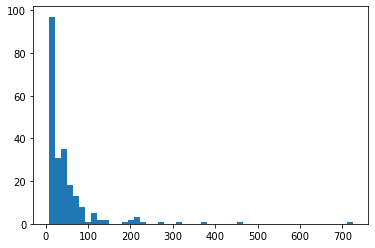

In [7]:
# users that filled out the questionnaire at least x times
x = 7
df_lim = df3[df3['count_tmp'] >= x]

print('number of users with at least '+str(x)+' entries: '+str(df_lim['responderId'].nunique()))
print('number of rows: '+str(len(df_lim.index)))
plt.hist(df_lim['responderId'].value_counts(), bins=50)

users with at least 7 entries and using only up to 200 entries (224 users)
number of rows: 9846


(array([39., 22., 27., 13., 11.,  8.,  6.,  5., 16.,  7.,  9.,  1.,  6.,
         6.,  5.,  3.,  3.,  5.,  3.,  2.,  3.,  1.,  1.,  0.,  0.,  1.,
         0.,  2.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., 10.]),
 array([  7.  ,  10.86,  14.72,  18.58,  22.44,  26.3 ,  30.16,  34.02,
         37.88,  41.74,  45.6 ,  49.46,  53.32,  57.18,  61.04,  64.9 ,
         68.76,  72.62,  76.48,  80.34,  84.2 ,  88.06,  91.92,  95.78,
         99.64, 103.5 , 107.36, 111.22, 115.08, 118.94, 122.8 , 126.66,
        130.52, 134.38, 138.24, 142.1 , 145.96, 149.82, 153.68, 157.54,
        161.4 , 165.26, 169.12, 172.98, 176.84, 180.7 , 184.56, 188.42,
        192.28, 196.14, 200.  ]),
 <a list of 50 Patch objects>)

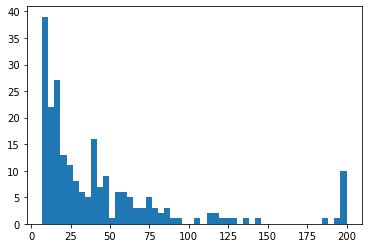

In [8]:
# retain only the y first entries
y = 200
df_lim = df_lim[df_lim['numerate_by_user_tmp'] <= y]

print('users with at least '+str(x)+' entries and using only up to '+str(y)+' entries ('+str(df_lim['responderId'].nunique())+ ' users)')
print('number of rows: '+str(len(df_lim.index)))
plt.hist(df_lim['responderId'].value_counts(), bins=50)

In [9]:
# remove unnecessary columns
df = df_lim.drop(columns=['count_tmp', 'numerate_by_user_tmp'])

# Check correlations

In [10]:
correlation_series = df.corr(method = 'spearman')['r_relapse'].abs().sort_values(ascending = False)
correlation_series[correlation_series > 0.01]

r_relapse                                         1.000000
r_persevere_difficulty_shifted_1                  0.212613
r_addiction_succumb_times_shifted_1               0.198592
r_craving_shifted_1                               0.188962
r_addiction_succumb_reason_7_shifted_1            0.170741
                                                    ...   
c_gambling                                        0.015348
c_masturbation                                    0.013600
q_treatment                                       0.011359
r_addiction_succumb_consequences2_13_shifted_1    0.010380
r_persevere_motivation_9_shifted_1                0.010021
Name: r_relapse, Length: 85, dtype: float64

In [11]:
# we note the imbalance of our two classes
df['r_relapse'].value_counts()

0.0    8133
1.0    1713
Name: r_relapse, dtype: int64

# Machine learning pipeline

This pipeline does nested cross-validation for classifying "r_relapse".

I am using StratifiedGroupKFold, because in order to avoid target leaking, each user should either be in the training OR the test set. Additionally, we want the classes (relapse/no relapse) to be of equal size (stratification).

Pipeline steps are: SMOTE (upsampling of the minority class), scaling, LGBM classifier

The code will run hyperparameter optimization with GridSearchCV for each StratifiedGroupKFold.

Because of the class imbalance, we use average precision (i.e., the precision-recall-curve) as the evaluation metric.
See https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432

In [12]:
# get group labels to avoid using data from the same user in train and test
groups = df.reset_index()['responderId'].tolist()

# make numpy array out of python list
groups = np.array(groups)

# need to remove responderId column, so it is not used as a feature
df = df.reset_index().drop(columns=['responderId', 'index'])

# define X and y
X = df.loc[:, df.columns != 'r_relapse']
y = df.loc[:, df.columns == 'r_relapse']
# these copies can be helpful for getting feature names later; for example, for feature importance:
X_df = X.copy()
y_df = y.copy() 
y = y['r_relapse']

# create numpy arrays for working smoothly with scikit-learn
X = X.values
y = y.values

inner_fold = 5
outer_fold = 5

# this will be used in GridSearchCV, generating train and test sets with StratifiedGroupKFold
inner_cv = StratifiedGroupKFold(n_splits=inner_fold)
outer_cv = StratifiedGroupKFold(n_splits=outer_fold)

In [13]:
# defining the pipeline
clf_pipe = Pipeline(
    steps=[
           ('smote', SMOTE(random_state=42)),
           ('maxabs', MaxAbsScaler()),
           ('lgbm', LGBMClassifier())
    ]
)

# setting the search space for GridSearchCV
search_space = [{'lgbm__num_leaves': [2,4,6,8,16,32],
                 'lgbm__max_depth': [-1,3,4,5,6,7,8,9,10,11,12],
                 'lgbm__learning_rate': [0.01,0.1,0.2,0.3],
                 'lgbm__n_estimators': [25,50,100,200,300,400,500,1000,1500],
                 'lgbm__deterministic': [True],
                 'lgbm__force_row_wise': [True]
                }]

In [ ]:
%%time

# counting the folds
cnt = 0

# for getting the average of the desired score
scores = []

search = ''

# for each outer fold, optimize the hyperparameters on the inner folds, while considering the groups
for train_index_curr, test_index_curr in outer_cv.split(X, y, groups):
    cnt += 1
    
    print("Fold "+str(cnt))
    
    train_index = train_index_curr
    test_index = test_index_curr
    print("TRAIN len: ", len(train_index), "TEST len: ", len(test_index))

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_df_train = X_df.iloc[train_index]
    y_df_train = y_df.iloc[train_index]

    X_df_test = X_df.iloc[test_index]
    y_df_test = y_df.iloc[test_index]
    print("test set distribution:")
    print(y_df_test['r_relapse'].value_counts(normalize=True))

    test_examples = y_df_test.shape[0]
    test_examples_positive = y_df_test[y_df_test['r_relapse'] == 1].shape[0]
    
    search = GridSearchCV(clf_pipe,
                      param_grid=search_space,
                      cv=inner_cv,
                      scoring='average_precision',
                      return_train_score=True,
                      verbose=10,
                      n_jobs=-1)
    search.fit(X_train, y_train, groups=groups[train_index])
    
    print('Best training params and score:')
    print(search.best_params_)
    print(search.best_score_)
    
    y_test_predict = search.predict(X_test)
    y_test_predict_proba = search.predict_proba(X_test)[:,1]
    
    print('test scores:')
    print('baseline for average_precision (number of positive examples/total examples): '+str(test_examples_positive/test_examples))
    print('average_precision: '+str(average_precision_score(y_test, y_test_predict_proba)))
    print('accuracy: '+str(accuracy_score(y_test, y_test_predict)))
    
    scores.append(average_precision_score(y_test, y_test_predict_proba))
    
    print(confusion_matrix(y_test, y_test_predict))
    print('\n')
    
    # store results of the fold
    fold = results(search, y_test, y_test_predict, X_test, X_train, y_train, groups,
                   y_df, X_df, train_index, test_index, cnt, clf_pipe, search_space)
    name = 'porno-pipeline'
    date = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    path = 'results/'
    pickle.dump(fold, open(path+str(date)+'-'+str(name)+'-fold-'+str(cnt)+'.pkl', 'wb'))
    
print(str(np.mean(scores)))

In [ ]:
# Please note: log output ommited here for size reasons; see next script for results